In [304]:
from lib.ekyn import get_ekyn_ids,load_ekyn_pt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,ConcatDataset
import math
from torch import nn
from lib.models import RegNet
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import torch
from lib.datasets import EpochedDataset
from tqdm import tqdm

CONFIG = {
    'WINDOW_SIZE':5000,
    'BATCH_SIZE':512,
    'LEARNING_RATE':1e-2,
    'DEVICE':'cuda'
}

train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
trainloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)
devloader = DataLoader(ConcatDataset([EpochedDataset(idx=idx,condition=condition) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=512,shuffle=True)

In [341]:
model = RegNet(in_features=5000,in_channels=1,depthi=[4],widthi=[32])
criterion = torch.nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([18.3846,  2.2810,  1.9716]))

optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'],weight_decay=1e-2)
model.to(CONFIG['DEVICE']);
criterion.to(CONFIG['DEVICE']);

In [342]:
lossi = []
devlossi = []

In [343]:
from lib.utils import development_loop
for i in tqdm(range(20)):
    for j,(Xi,yi) in enumerate(trainloader):
        Xi,yi = Xi.to(CONFIG['DEVICE']),yi.to(CONFIG['DEVICE'])
        logits = model(Xi)
        loss = criterion(logits,yi)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
    loss,f1 = development_loop(model,devloader,criterion,CONFIG['DEVICE'])
    devlossi.append(loss)
loss

100%|██████████| 20/20 [11:53<00:00, 35.68s/it]


0.2864080000806738

In [344]:
devlossi

[0.3192150890827179,
 0.3066255602571699,
 0.2964599518864243,
 0.28221989914223,
 0.29105254853213275,
 0.27375580547032535,
 0.2978771760507866,
 0.2766266793012619,
 0.27842580124183935,
 0.2819461903086415,
 0.27736819242989574,
 0.2885174624345921,
 0.27919968057561806,
 0.32931398572745146,
 0.3539931849197105,
 0.28931884975345046,
 0.27638602179509625,
 0.2723601612779829,
 0.2983379562695821,
 0.2864080000806738]

In [345]:
lossi

[1.817667007446289,
 1.1910274028778076,
 0.9135004281997681,
 0.857370913028717,
 0.8642365336418152,
 0.8639945983886719,
 0.9030778408050537,
 0.8834151029586792,
 0.8483972549438477,
 0.8564921021461487,
 0.9090322256088257,
 0.8734391331672668,
 0.9526767730712891,
 0.8930554389953613,
 0.8683329224586487,
 0.8787723183631897,
 0.863966703414917,
 0.8492257595062256,
 0.8840234279632568,
 0.8416950702667236,
 0.7986548542976379,
 0.8625220060348511,
 0.8437524437904358,
 0.8043882250785828,
 0.8372486233711243,
 0.8324626684188843,
 0.8020808696746826,
 0.8072348833084106,
 0.8350579738616943,
 0.8064389228820801,
 0.8207739591598511,
 0.7578359246253967,
 0.8298208713531494,
 0.7935336828231812,
 0.7962771654129028,
 0.7965222597122192,
 0.7671363353729248,
 0.7891855239868164,
 0.778492271900177,
 0.7406488656997681,
 0.7417530417442322,
 0.7533361911773682,
 0.7547519207000732,
 0.7283637523651123,
 0.7586058378219604,
 0.7400964498519897,
 0.7145254611968994,
 0.71542048454284

tensor(0.2724)

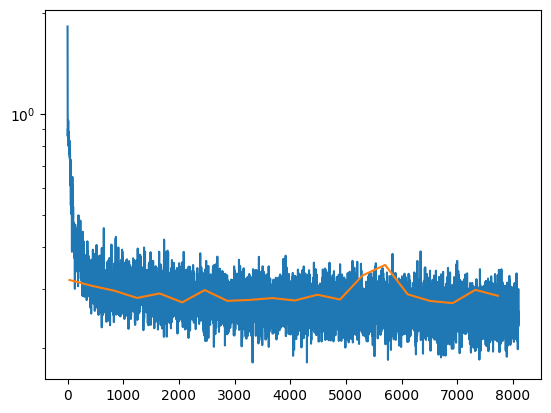

In [346]:
plt.plot(lossi)
plt.plot(range(34,len(lossi) + 1,len(trainloader)),devlossi)
# plt.xlim([len(lossi),len(lossi)])
plt.yscale('log')
# plt.ylim([0,1])
torch.tensor(devlossi).min()

100%|██████████| 405/405 [00:12<00:00, 32.63it/s]


              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73     11279
         1.0       0.93      0.92      0.92     90907
         2.0       0.90      0.92      0.91    105174

    accuracy                           0.91    207360
   macro avg       0.88      0.84      0.85    207360
weighted avg       0.91      0.91      0.91    207360

0.23946575007320922


100%|██████████| 135/135 [00:04<00:00, 33.43it/s]


              precision    recall  f1-score   support

         0.0       0.59      0.53      0.56      3504
         1.0       0.95      0.90      0.92     31617
         2.0       0.87      0.92      0.90     33999

    accuracy                           0.89     69120
   macro avg       0.80      0.78      0.79     69120
weighted avg       0.89      0.89      0.89     69120

0.2864079987561261


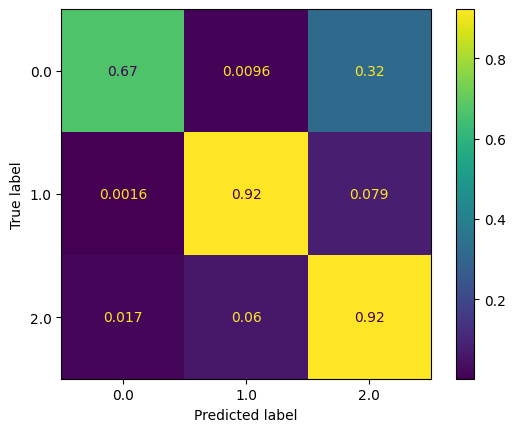

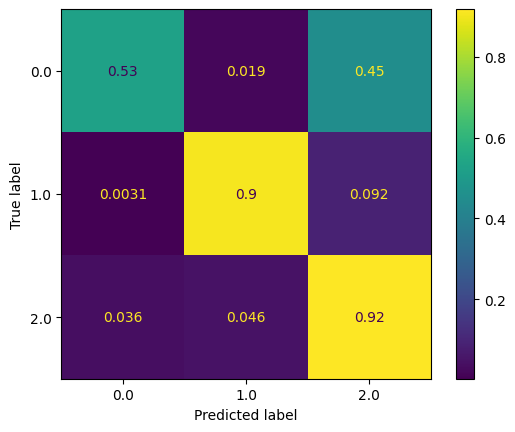

In [347]:
from lib.utils import evaluate
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

loss,report,y_true,y_pred,y_logits = evaluate(dataloader=trainloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)
loss,report,y_true,y_pred,y_logits = evaluate(dataloader=devloader,model=model,criterion=criterion,DEVICE=CONFIG['DEVICE'])
ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)
# unweighted dev record
# 0.2864

# weighted dev record
# tensor(1.5405)

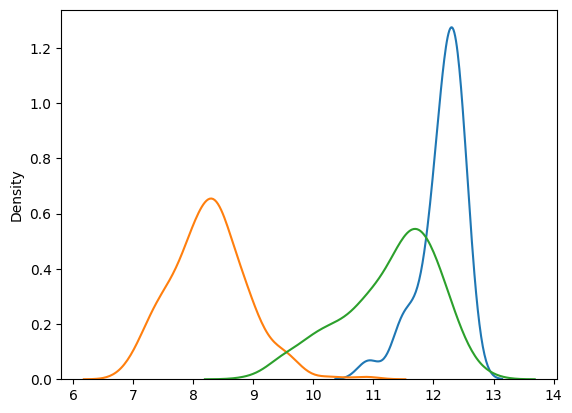

In [164]:
import seaborn as sns
model.to('cpu')
Xi,yi = next(iter(trainloader))
feature_map_idx = 3
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 0)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 1)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());
sns.kdeplot(model(Xi[torch.where(yi.argmax(axis=1) == 2)[0]],return_encoding=True)[:,feature_map_idx].detach().flatten());

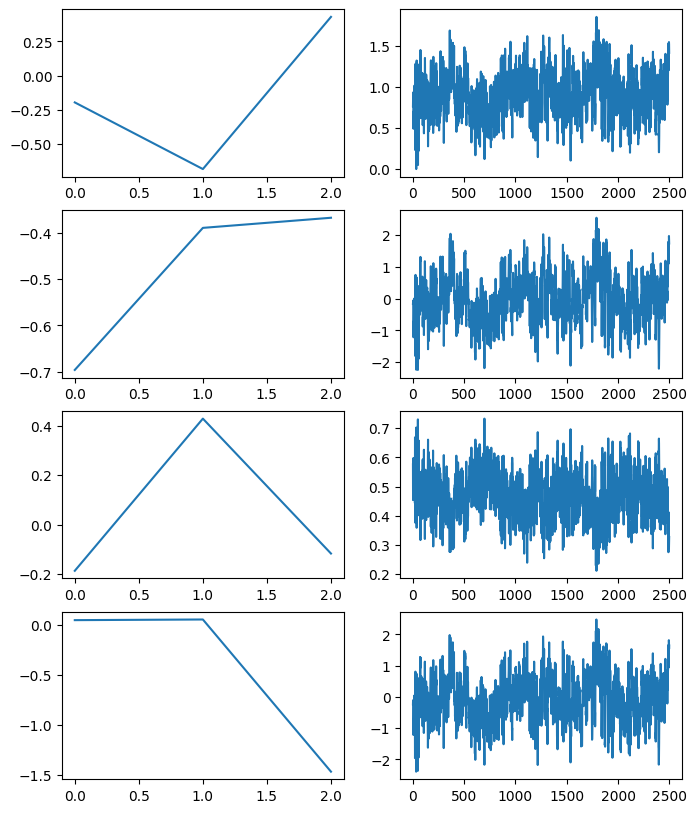

In [165]:
model.to('cpu')
Xi,yi = next(iter(trainloader))

fig,ax = plt.subplots(nrows=len(model.c1.weight),ncols=2,figsize=(8,10))
for i,kernel in enumerate(model.c1.weight.squeeze().detach()):
    ax[i,0].plot(kernel)
for i,kernel in enumerate(model.c1(Xi.reshape(-1,1,5000)).detach()[0]):
    ax[i,1].plot(kernel)